In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r /content/drive/MyDrive/Objectdetection/data /content

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 326422, done.
remote: Counting objects: 100% (326422/326422), done.
remote: Compressing objects: 100% (25537/25537), done.
remote: Total 326422 (delta 300261), reused 325309 (delta 299258), pack-reused 0
Receiving objects: 100% (326422/326422), 658.78 MiB | 22.42 MiB/s, done.
Resolving deltas: 100% (300261/300261), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [6]:
!rm -rf /content/data/.ipynb_checkpoints
!rm -rf /content/data/test/.ipynb_checkpoints
!rm -rf /content/data/train/.ipynb_checkpoints

In [7]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

In [13]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 5 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5

dataset = CityDataset('/content/data/train', get_transform(train=True))
dataset_test = CityDataset('/content/data/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/21]  eta: 0:03:12  lr: 0.000255  loss: 2.7797 (2.7797)  loss_classifier: 1.5359 (1.5359)  loss_box_reg: 0.7953 (0.7953)  loss_objectness: 0.4042 (0.4042)  loss_rpn_box_reg: 0.0444 (0.0444)  time: 9.1888  data: 0.3826  max mem: 3180
Epoch: [0]  [10/21]  eta: 0:00:16  lr: 0.002752  loss: 1.9838 (1.8147)  loss_classifier: 1.0140 (0.9753)  loss_box_reg: 0.5139 (0.5254)  loss_objectness: 0.2041 (0.2559)  loss_rpn_box_reg: 0.0431 (0.0581)  time: 1.4771  data: 0.0471  max mem: 3337
Epoch: [0]  [20/21]  eta: 0:00:01  lr: 0.005000  loss: 1.3801 (1.6070)  loss_classifier: 0.5762 (0.7728)  loss_box_reg: 0.5528 (0.5571)  loss_objectness: 0.1334 (0.2124)  loss_rpn_box_reg: 0.0431 (0.0646)  time: 0.7012  data: 0.0137  max mem: 3338
Epoch: [0] Total time: 0:00:23 (1.1116 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:02  model_time: 0.2155 (0.2155)  evaluator_time: 0.0350 (0.0350)  time: 0.5648  data: 0.3115  max mem: 3338
Test:  [4/5]  eta: 0:00:00  model_time: 0.15

In [25]:
def get_inference(img_path,model):
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    idx = next(x for x, val in enumerate(scores) if val < 0.7)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    return out

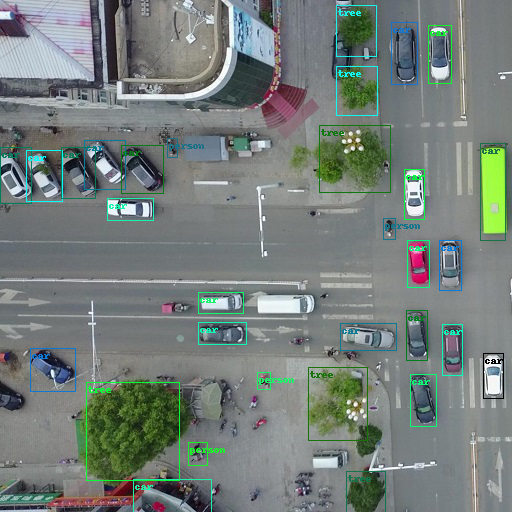

In [26]:
img = get_inference('/content/test_img.jpg',model)
img.show()